# HIV DATA ANALYSIS

### Overview 

In the first part of the analysis we're provided with a dataset from the World Health Organization (WHO) Global Observatory, containing data on people living with HIV at the country level from 2000 to 2023.

This data will be analysed to create visualizations the trend of countries that contribute 75% to the global burden and repeat the same for countries within each WHO region.   

The analysis will have two parts:
1. Visualization of HIV cases trends in countries that contribute to 75% of the global burden.
2. Visualization of HIV cases trends in countries that contribute to 75% of the global burden in each WHO region.

The analysis will begin with cleaning data, using pandas library to perform data imputation, matplotlib and seaborn for visualizations.

In [6]:
#import necessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import re
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
#Load the data 

hiv_data= pd.read_csv('HIV data 2000-2023.csv' , encoding='latin1')
hiv_data.head()

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,Value
0,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2023,320 000 [280 000 - 380 000]
1,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2022,320 000 [280 000 - 380 000]
2,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2021,320 000 [280 000 - 380 000]
3,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2020,320 000 [280 000 - 370 000]
4,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2015,300 000 [260 000 - 350 000]


Next, the info method is used to view the data and get insights into it. 

From it, we can see that the data has no missing values, the are only object and integer data types.

In [3]:
hiv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552 entries, 0 to 1551
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   IndicatorCode        1552 non-null   object
 1   Indicator            1552 non-null   object
 2   ValueType            1552 non-null   object
 3   ParentLocationCode   1552 non-null   object
 4   ParentLocation       1552 non-null   object
 5   Location type        1552 non-null   object
 6   SpatialDimValueCode  1552 non-null   object
 7   Location             1552 non-null   object
 8   Period type          1552 non-null   object
 9   Period               1552 non-null   int64 
 10  Value                1552 non-null   object
dtypes: int64(1), object(10)
memory usage: 133.5+ KB


In [4]:
hiv_data['Value'].value_counts()

Value
No data                        394
<500 [<500 - <500]              26
<200 [<100 - <200]               9
<100 [<100 - <100]               8
140 000 [120 000 - 160 000]      8
                              ... 
51 000 [44 000 - 58 000]         1
49 000 [43 000 - 56 000]         1
48 000 [42 000 - 54 000]         1
46 000 [41 000 - 52 000]         1
180 000 [150 000 - 200 000]      1
Name: count, Length: 895, dtype: int64

In [5]:
hiv_data.columns

Index(['IndicatorCode', 'Indicator', 'ValueType', 'ParentLocationCode',
       'ParentLocation', 'Location type', 'SpatialDimValueCode', 'Location',
       'Period type', 'Period', 'Value'],
      dtype='object')

 We have countries that have missing data for the whole time period from 2000-2023 and those that have partially missing data.
 I dropped the countries that have complete missing data and computed for those that have partially missing data.

In [7]:
# Replace 'no data' with NaN
hiv_data['Value'] = hiv_data['Value'].replace('No data', np.nan)


# Function to extract point estimate
def extract_point_estimate(value_str):
    if pd.isna(value_str):
        return np.nan
    match = re.search(r'(\d[\d\s]*)(?=\s*\[)', value_str)
    if match:
        return int(match.group(1).replace(" ", ""))
    return np.nan

# Apply to cleaned column
hiv_data['Value_Clean'] = hiv_data['Value'].apply(extract_point_estimate)


# Drop countries where Value_Clean is NaN for all years
hiv_data = hiv_data[hiv_data.groupby('Location')['Value_Clean'].transform('count') > 0]


In [8]:
hiv_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1176 entries, 0 to 1535
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   IndicatorCode        1176 non-null   object 
 1   Indicator            1176 non-null   object 
 2   ValueType            1176 non-null   object 
 3   ParentLocationCode   1176 non-null   object 
 4   ParentLocation       1176 non-null   object 
 5   Location type        1176 non-null   object 
 6   SpatialDimValueCode  1176 non-null   object 
 7   Location             1176 non-null   object 
 8   Period type          1176 non-null   object 
 9   Period               1176 non-null   int64  
 10  Value                1158 non-null   object 
 11  Value_Clean          1158 non-null   float64
dtypes: float64(1), int64(1), object(10)
memory usage: 119.4+ KB


In [9]:
hiv_data['Value_Clean'].value_counts() 

Value_Clean
500.0        36
200.0        25
110000.0     25
120000.0     24
14000.0      20
             ..
740000.0      1
3600000.0     1
4900000.0     1
5900000.0     1
180000.0      1
Name: count, Length: 284, dtype: int64

##### Impute missing years for countries with partial data

In [10]:
# Fill missing values with forward then backward fill
hiv_data['Value_Clean'] = hiv_data.groupby('Location')['Value_Clean'].transform(lambda x: x.ffill().bfill())


country_total = hiv_data.groupby('Location')['Value_Clean'].sum().sort_values(ascending=False)





Find countries contributing to 75% of the global burden

In [11]:
# Total burden
global_total = country_total.sum()
threshold = 0.75 * global_total

# Find top contributors cumulatively
cumulative = country_total.cumsum()
top_countries = cumulative[cumulative <= threshold].index.tolist()

print("Countries contributing to 75% of HIV burden:")
print(top_countries)


Countries contributing to 75% of HIV burden:
['South Africa', 'India', 'Mozambique', 'Nigeria', 'Kenya', 'United Republic of Tanzania', 'Zimbabwe', 'Uganda', 'Zambia', 'Malawi', 'Brazil', 'Thailand', 'Ethiopia', 'Democratic Republic of the Congo']


In [12]:
hiv_data

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,Value,Value_Clean
0,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2023,320 000 [280 000 - 380 000],320000.0
1,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2022,320 000 [280 000 - 380 000],320000.0
2,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2021,320 000 [280 000 - 380 000],320000.0
3,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2020,320 000 [280 000 - 370 000],320000.0
4,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2015,300 000 [260 000 - 350 000],300000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1531,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,WPR,Western Pacific,Country,VNM,Viet Nam,Year,2020,250 000 [230 000 - 270 000],250000.0
1532,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,WPR,Western Pacific,Country,VNM,Viet Nam,Year,2015,240 000 [210 000 - 260 000],240000.0
1533,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,WPR,Western Pacific,Country,VNM,Viet Nam,Year,2010,210 000 [190 000 - 230 000],210000.0
1534,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,WPR,Western Pacific,Country,VNM,Viet Nam,Year,2005,180 000 [150 000 - 200 000],180000.0


In [13]:
# 4. Filter dataframe to remain with the top countries 

hiv_data_top_countries = hiv_data[hiv_data['Location'].isin(top_countries)]

##### Visualization of HIV cases trends over time in top_countries

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


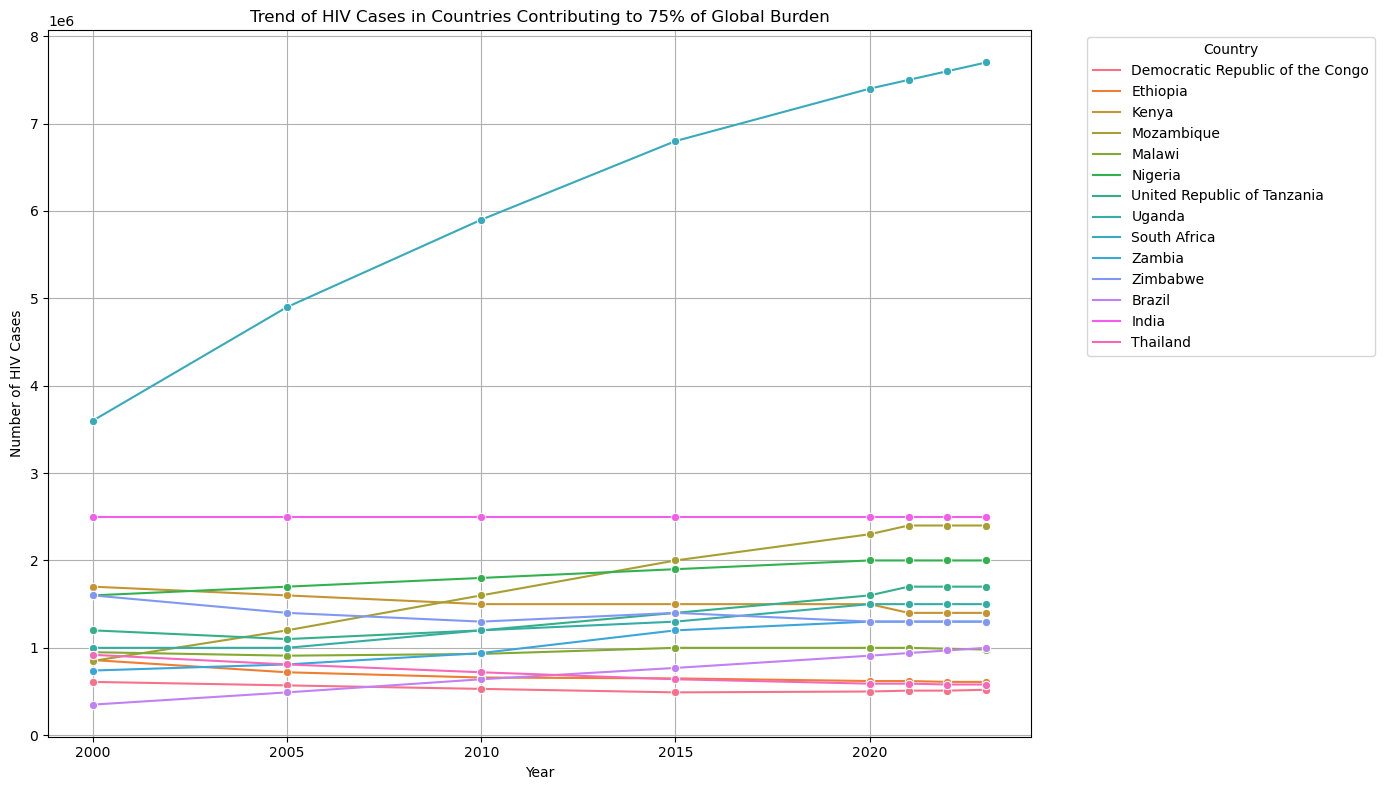

In [14]:
# 5. Plot trends over time
plt.figure(figsize=(14, 8))
sns.lineplot(data=hiv_data_top_countries, x='Period', y='Value_Clean', hue='Location', marker="o")
plt.title('Trend of HIV Cases in Countries Contributing to 75% of Global Burden')
plt.ylabel('Number of HIV Cases')
plt.xlabel('Year')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

The second part: I created a visualization that displays the trend of HIV cases in the countries contributing to 75% of the burden within each WHO region

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


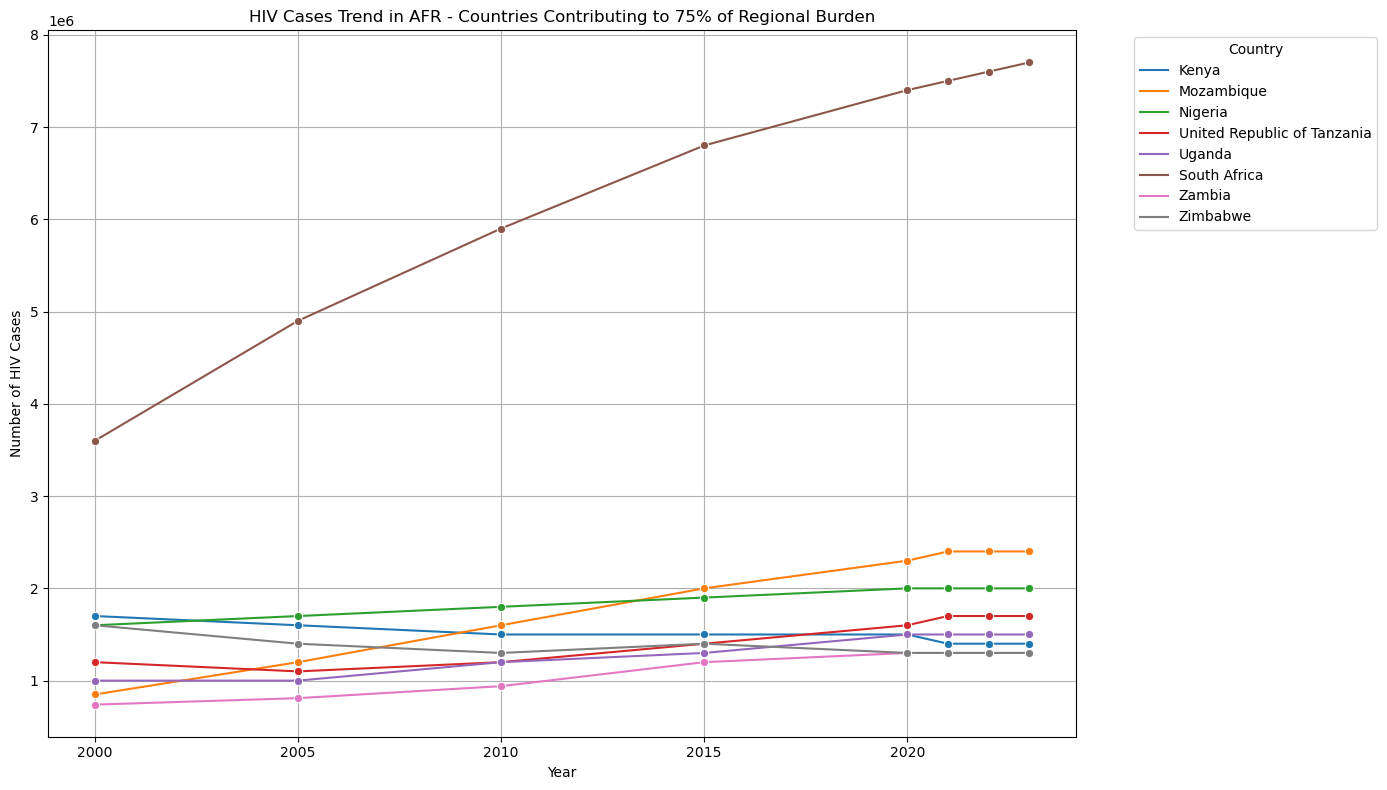

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


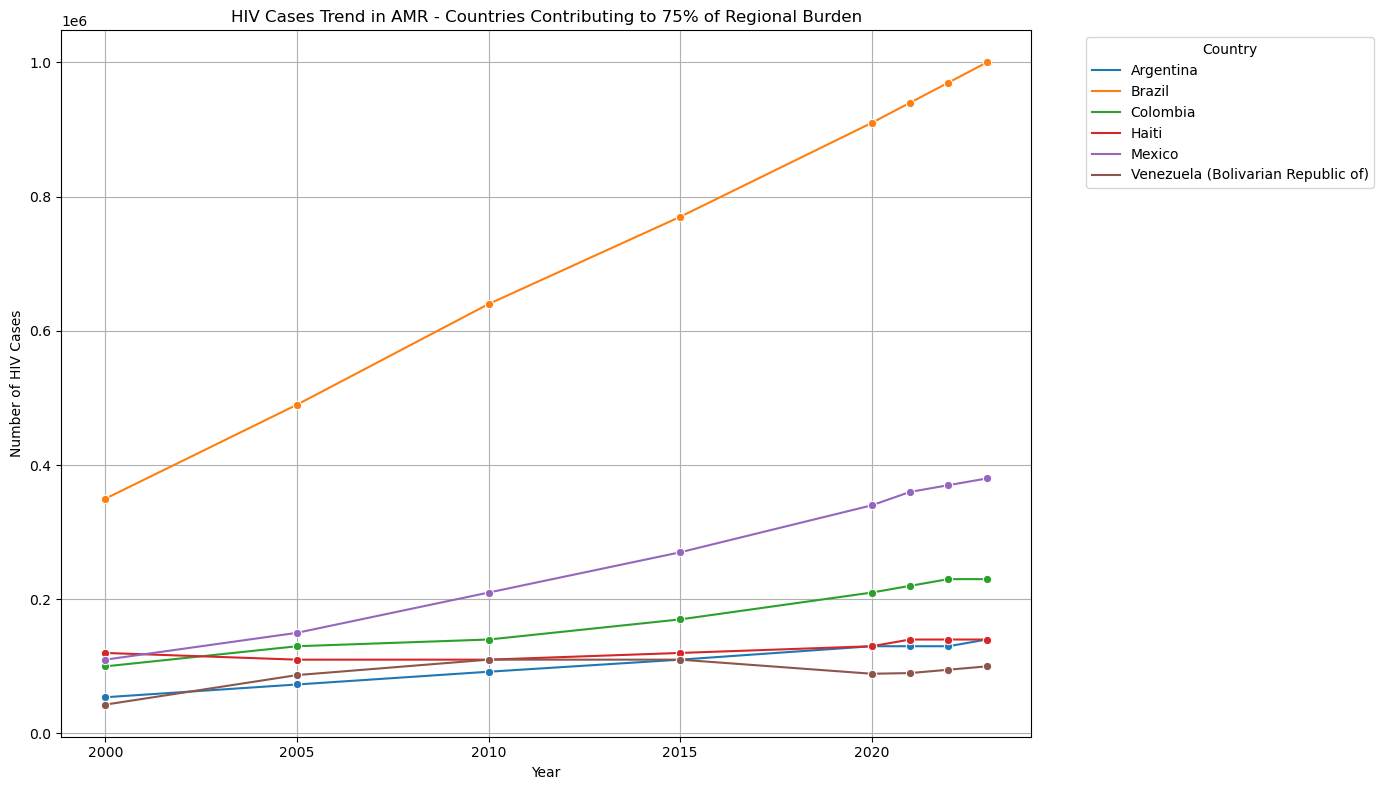

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


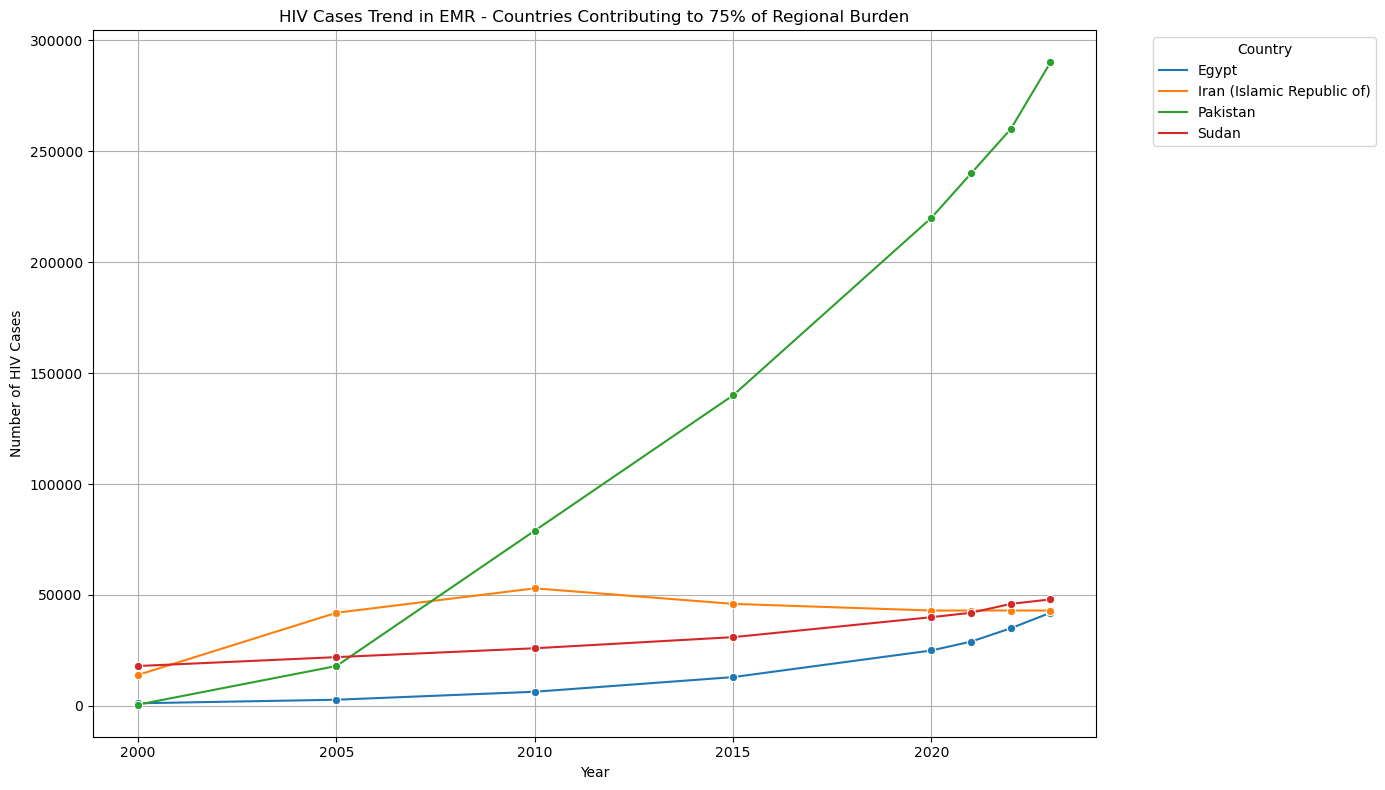

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


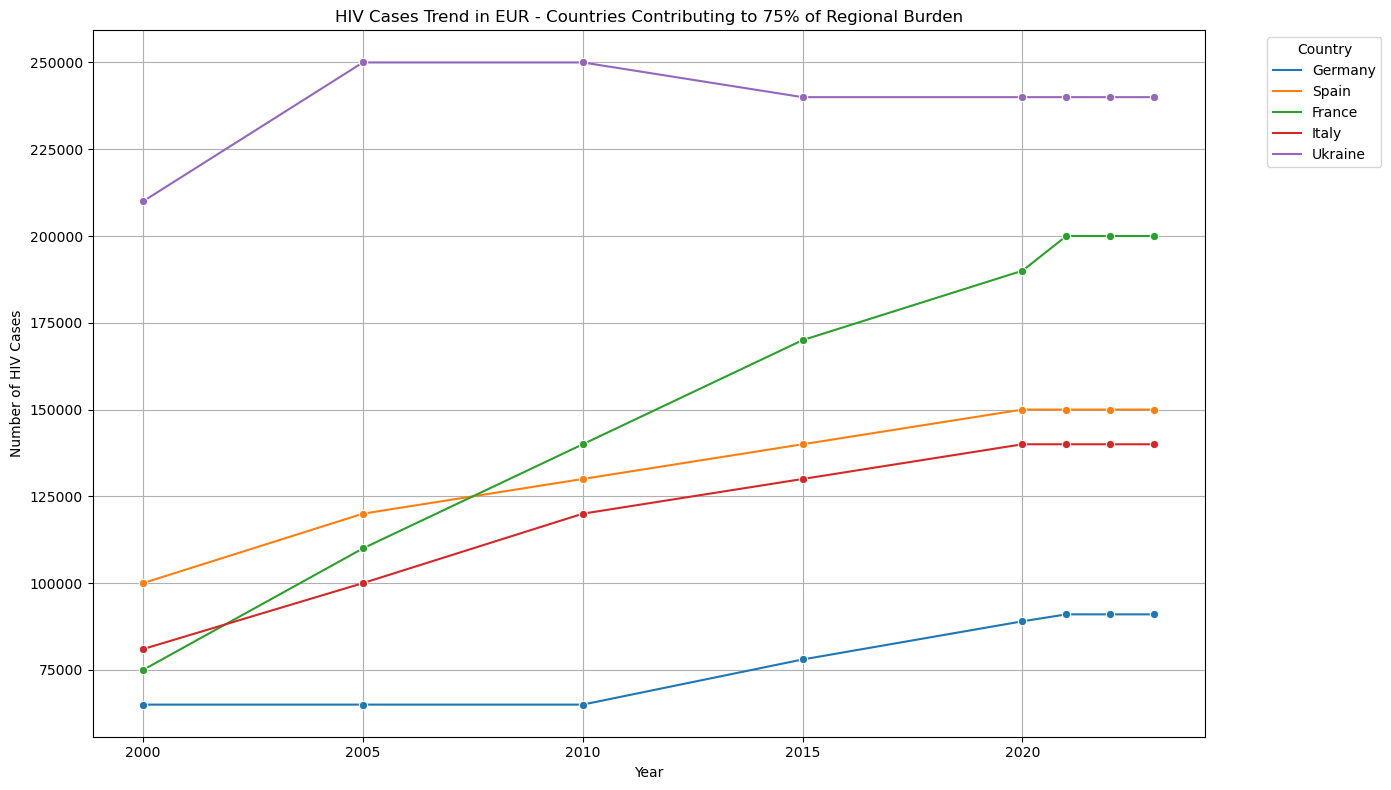

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


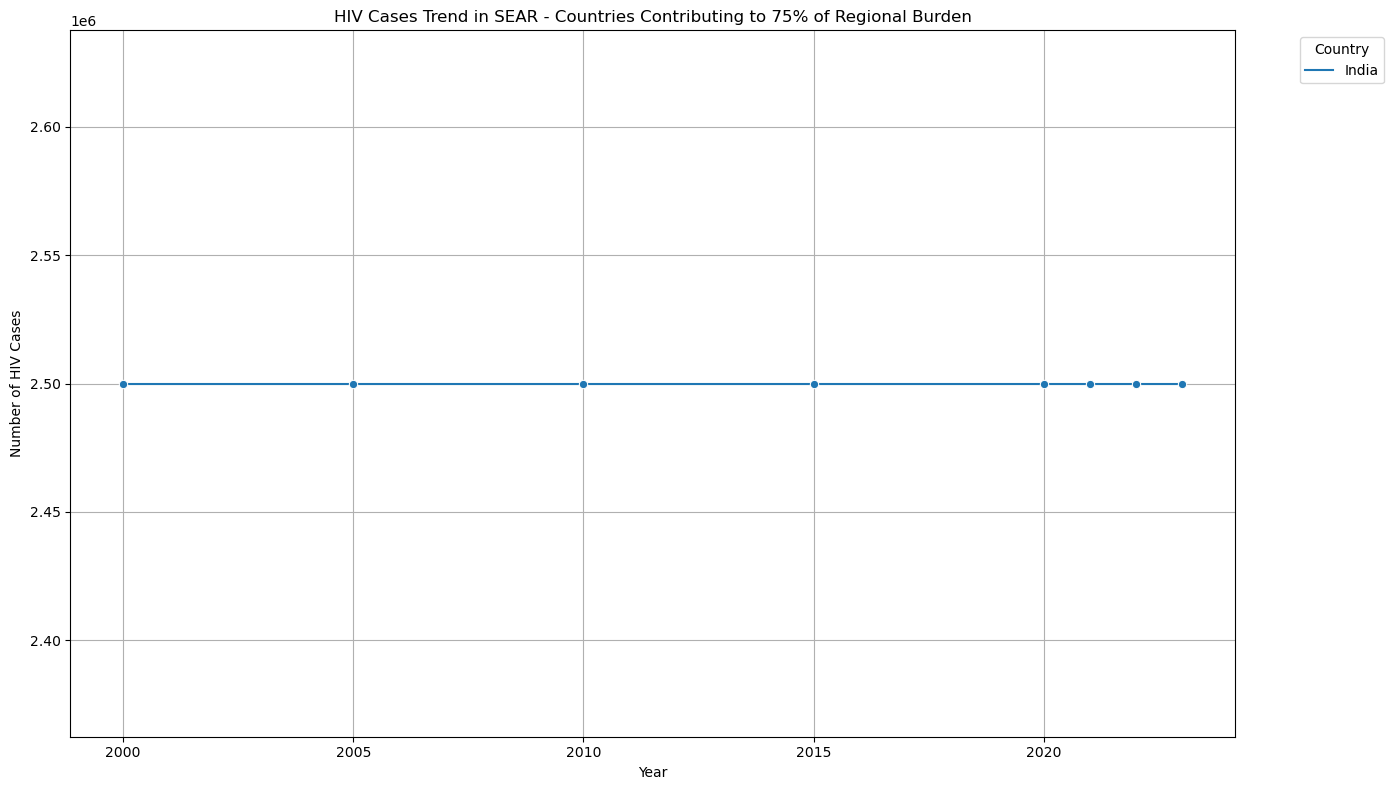

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


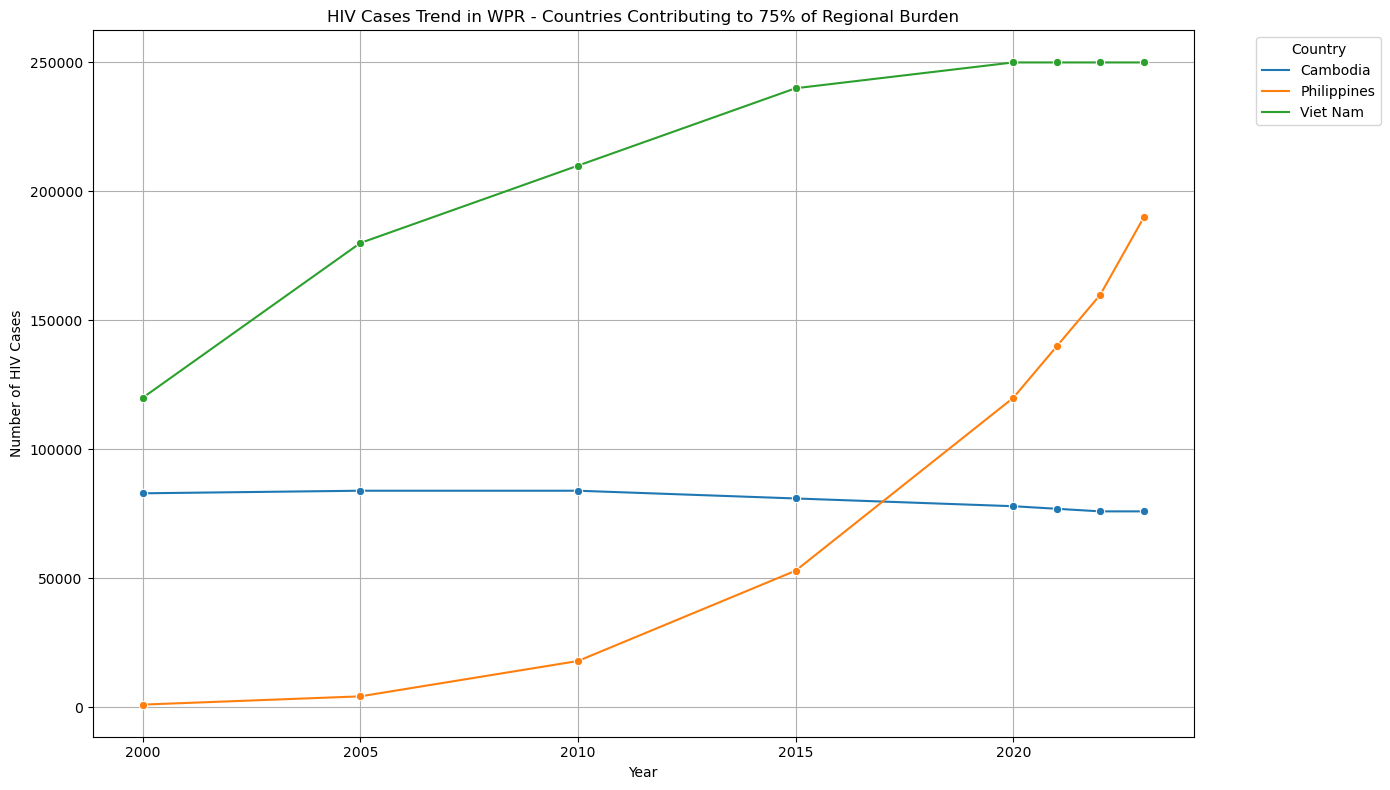

In [15]:
# Group data by region
regions = hiv_data['ParentLocationCode'].unique()

for region in regions:
    hiv_data_region = hiv_data[hiv_data['ParentLocationCode'] == region]
    
    # Sum total burden per country within region
    country_burden_region = hiv_data_region.groupby('Location')['Value_Clean'].sum().sort_values(ascending=False)
    
    # Find countries contributing to 75% of regional burden
    total_burden_region = country_burden_region.sum()
    cumulative_region = country_burden_region.cumsum()
    top_countries_region = cumulative_region[cumulative_region <= 0.75 * total_burden_region].index.tolist()
    
    # Filter
    hiv_top_countries_region = hiv_data_region[hiv_data_region['Location'].isin(top_countries_region)]
    
    # Plot
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=hiv_top_countries_region, x='Period', y='Value_Clean', hue='Location', marker="o")
    plt.title(f'HIV Cases Trend in {region} - Countries Contributing to 75% of Regional Burden')
    plt.ylabel('Number of HIV Cases')
    plt.xlabel('Year')
    plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


For the second part of the analysis, we've been provided with World Bank data on the multidimensional poverty headcount ratio, which includes factors such as income, educational attainment, school enrolment, electricity access, sanitation and drinking water.

###### Objectives 

Merge this dataset with the HIV data  and analyze the relationship between people living with HIV and multidimensional poverty, and the individual factors that contribute to the ratio. Ad account for the random effects(country, year)

Paragraph the findings 

In [16]:
multidimensional_pov= pd.read_excel('multidimensional_poverty.xlsx', header=1)

multidimensional_pov

,Region,Country code,Economy,Reporting year,Survey name,Survey year,Survey coverage,Welfare type,Survey comparability,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Multidimensional poverty headcount ratio (%)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Monetary (%),Educational attainment (%),Educational enrollment (%),Electricity (%),Sanitation (%),Drinking water (%),NaN
1,SSA,AGO,Angola,2018.0,IDREA,2018.0,N,c,2.0,31.122005,29.753423,27.44306,52.639532,53.637516,32.106507,47.203606
2,ECA,ALB,Albania,2012.0,HBS,2018.0,N,c,1.0,0.048107,0.19238,-,0.06025,6.579772,9.594966,0.293161
3,LAC,ARG,Argentina,2010.0,EPHC-S2,2021.0,U,i,3.0,0.894218,1.08532,0.731351,0,0.257453,0.364048,0.906573
4,ECA,ARM,Armenia,2010.0,ILCS,2021.0,N,c,1.0,0.523521,0,1.793004,0,0.397725,0.660082,0.523521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,ECA,UZB,Uzbekistan,2022.0,HBS,2022.0,N,c,1.0,2.253092,0,-,0.12747,21.786885,10.693686,2.253092
107,EAP,VNM,Viet Nam,2010.0,VHLSS,2022.0,N,c,2.0,0.963795,3.384816,1.841407,0.079733,4.132901,1.968127,1.266184
108,EAP,VUT,Vanuatu,2010.0,NSDP,2019.0,N,c,0.0,9.963333,25.723079,13.404277,26.994166,42.970088,11.813611,19.892171
109,SSA,ZMB,Zambia,2010.0,LCMS-VIII,2022.0,N,c,4.0,64.341974,16.267821,23.39835,45.135146,53.505135,26.849246,66.506058


In [17]:
multidimensional_pov.columns

Index(['Region', 'Country code', 'Economy', 'Reporting year', 'Survey name',
       'Survey year', 'Survey coverage', 'Welfare type',
       'Survey comparability', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14',
       'Multidimensional poverty headcount ratio (%)'],
      dtype='object')

##### Data cleaning 
We first set the column names correctly for analysis.

In [18]:
# Get the new column names from row 0 (Monetary (%) to Sanitation (%))
new_columns = multidimensional_pov.iloc[0, 9:15].tolist()  # Positions 10 to 15

all_columns = (
    multidimensional_pov.columns[:9].tolist() +  # First 9 original columns
    new_columns +              # 5 new names for columns 9-13
    multidimensional_pov.columns[15:].tolist()   # Remaining columns (14 onwards)
)

# Assign the new column names
multidimensional_pov.columns = all_columns


# Drop row 0 since we've used it for partial column names
multidimensional_pov = multidimensional_pov.drop(0)

# Reset the index 
multidimensional_pov = multidimensional_pov.reset_index(drop=True)

# Display the cleaned DataFrame
multidimensional_pov

,Region,Country code,Economy,Reporting year,Survey name,Survey year,Survey coverage,Welfare type,Survey comparability,Monetary (%),Educational attainment (%),Educational enrollment (%),Electricity (%),Sanitation (%),Drinking water (%),Multidimensional poverty headcount ratio (%)
0,SSA,AGO,Angola,2018.0,IDREA,2018.0,N,c,2.0,31.122005,29.753423,27.44306,52.639532,53.637516,32.106507,47.203606
1,ECA,ALB,Albania,2012.0,HBS,2018.0,N,c,1.0,0.048107,0.19238,-,0.06025,6.579772,9.594966,0.293161
2,LAC,ARG,Argentina,2010.0,EPHC-S2,2021.0,U,i,3.0,0.894218,1.08532,0.731351,0,0.257453,0.364048,0.906573
3,ECA,ARM,Armenia,2010.0,ILCS,2021.0,N,c,1.0,0.523521,0,1.793004,0,0.397725,0.660082,0.523521
4,EAP,AUS,Australia,2010.0,SIH-LIS,2018.0,N,I,3.0,0.51688,1.71188,-,0,0,-,2.215770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,ECA,UZB,Uzbekistan,2022.0,HBS,2022.0,N,c,1.0,2.253092,0,-,0.12747,21.786885,10.693686,2.253092
106,EAP,VNM,Viet Nam,2010.0,VHLSS,2022.0,N,c,2.0,0.963795,3.384816,1.841407,0.079733,4.132901,1.968127,1.266184
107,EAP,VUT,Vanuatu,2010.0,NSDP,2019.0,N,c,0.0,9.963333,25.723079,13.404277,26.994166,42.970088,11.813611,19.892171
108,SSA,ZMB,Zambia,2010.0,LCMS-VIII,2022.0,N,c,4.0,64.341974,16.267821,23.39835,45.135146,53.505135,26.849246,66.506058


In [19]:
multidimensional_pov.columns

Index(['Region', 'Country code', 'Economy', 'Reporting year', 'Survey name',
       'Survey year', 'Survey coverage', 'Welfare type',
       'Survey comparability', 'Monetary (%)', 'Educational attainment (%)',
       'Educational enrollment (%)', 'Electricity (%)', 'Sanitation (%)',
       'Drinking water (%)', 'Multidimensional poverty headcount ratio (%)'],
      dtype='object')

###### Merge HIV_dataset with multidimensional_poverty data

In [20]:
hiv_data.head()

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,Value,Value_Clean
0,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2023,320 000 [280 000 - 380 000],320000.0
1,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2022,320 000 [280 000 - 380 000],320000.0
2,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2021,320 000 [280 000 - 380 000],320000.0
3,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2020,320 000 [280 000 - 370 000],320000.0
4,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2015,300 000 [260 000 - 350 000],300000.0


In [21]:
hiv_multidimensional = hiv_data.merge(
    multidimensional_pov,
    left_on='SpatialDimValueCode',
    right_on='Country code',
    how='left'
)


hiv_multidimensional

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,Survey coverage,Welfare type,Survey comparability,Monetary (%),Educational attainment (%),Educational enrollment (%),Electricity (%),Sanitation (%),Drinking water (%),Multidimensional poverty headcount ratio (%)
0,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2023,...,N,c,2.0,31.122005,29.753423,27.44306,52.639532,53.637516,32.106507,47.203606
1,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2022,...,N,c,2.0,31.122005,29.753423,27.44306,52.639532,53.637516,32.106507,47.203606
2,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2021,...,N,c,2.0,31.122005,29.753423,27.44306,52.639532,53.637516,32.106507,47.203606
3,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2020,...,N,c,2.0,31.122005,29.753423,27.44306,52.639532,53.637516,32.106507,47.203606
4,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,AFR,Africa,Country,AGO,Angola,Year,2015,...,N,c,2.0,31.122005,29.753423,27.44306,52.639532,53.637516,32.106507,47.203606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,WPR,Western Pacific,Country,VNM,Viet Nam,Year,2020,...,N,c,2.0,0.963795,3.384816,1.841407,0.079733,4.132901,1.968127,1.266184
1172,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,WPR,Western Pacific,Country,VNM,Viet Nam,Year,2015,...,N,c,2.0,0.963795,3.384816,1.841407,0.079733,4.132901,1.968127,1.266184
1173,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,WPR,Western Pacific,Country,VNM,Viet Nam,Year,2010,...,N,c,2.0,0.963795,3.384816,1.841407,0.079733,4.132901,1.968127,1.266184
1174,HIV_0000000001,Estimated number of people (all ages) living w...,numeric,WPR,Western Pacific,Country,VNM,Viet Nam,Year,2005,...,N,c,2.0,0.963795,3.384816,1.841407,0.079733,4.132901,1.968127,1.266184


In [22]:
hiv_multidimensional.columns

Index(['IndicatorCode', 'Indicator', 'ValueType', 'ParentLocationCode',
       'ParentLocation', 'Location type', 'SpatialDimValueCode', 'Location',
       'Period type', 'Period', 'Value', 'Value_Clean', 'Region',
       'Country code', 'Economy', 'Reporting year', 'Survey name',
       'Survey year', 'Survey coverage', 'Welfare type',
       'Survey comparability', 'Monetary (%)', 'Educational attainment (%)',
       'Educational enrollment (%)', 'Electricity (%)', 'Sanitation (%)',
       'Drinking water (%)', 'Multidimensional poverty headcount ratio (%)'],
      dtype='object')

###### Analyze relationship between people living with HIV and multidimensional poverty.

I calculated the Pearson correlation coefficient between the number of people living with HIV (Value_Clean) and the multidimensional poverty headcount ratio. 

The correlation value: 0.46 is close to 1, indicates a moderate positive correlation between the estimated number of people living with HIV and the multidimensional poverty headcount ratio. 

This suggests that, in general, as poverty levels increase, the number of people living with HIV also tends to increase. However, the relationship is not very strong, implying that poverty is not the only factor influencing HIV prevalence. 

The scatter plot visually represents this relationship. Each point on the plot represents a data point (a country or region) with its corresponding values for HIV prevalence and poverty.

The upward trend of the points from left to right confirms the positive correlation.
The spread of the points indicates that the relationship is not perfectly linear; there is some variability.
In summary, the analysis suggests a connection between HIV prevalence and poverty, but other factors are also likely to play a significant role.

Correlation between HIV and Poverty: 0.46


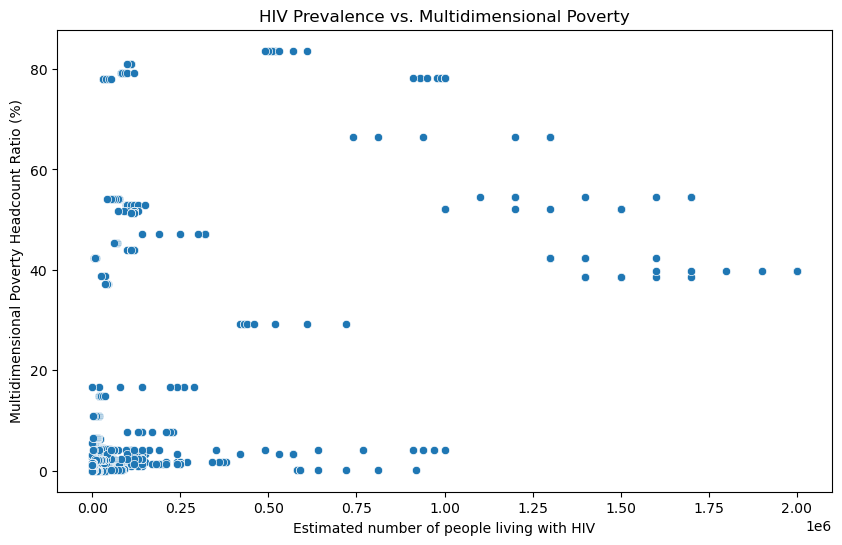

In [108]:
# 1. Correlation Analysis
correlation = hiv_multidimensional['Value_Clean'].corr(hiv_multidimensional['Multidimensional poverty headcount ratio (%)'])
print(f"Correlation between HIV and Poverty: {correlation:.2f}")

# 2. Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=hiv_multidimensional, x='Value_Clean', y='Multidimensional poverty headcount ratio (%)')
plt.title('HIV Prevalence vs. Multidimensional Poverty')
plt.xlabel('Estimated number of people living with HIV')
plt.ylabel('Multidimensional Poverty Headcount Ratio (%)')
plt.show()

In [27]:
if 'Multidimensional poverty headcount ratio (%)' in hiv_multidimensional.columns:
    hiv_multidimensional = hiv_multidimensional.rename(columns={'Multidimensional poverty headcount ratio (%)': 'multidimensional_poverty_ratio'})


if 'Country code' in hiv_multidimensional.columns:
    hiv_multidimensional = hiv_multidimensional.rename(columns={'Country code': 'Country_code'})
    

# 3. Regression Analysis
# Fixed effects regression
model_re = sm.MixedLM("Value_Clean ~ multidimensional_poverty_ratio", data=hiv_multidimensional, groups=hiv_multidimensional["Country_code"]).fit()
print(model_re.summary())

# 4. Grouped analysis by poverty levels
poverty_bins = pd.qcut(hiv_multidimensional['multidimensional_poverty_ratio'], q=3, labels=['Low Poverty', 'Medium Poverty', 'High Poverty'])
grouped_df = hiv_multidimensional.groupby(poverty_bins)['Value_Clean'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='multidimensional_poverty_ratio', y='Value_Clean', data=grouped_df)
plt.title('Average HIV Prevalence by Poverty Level')
plt.xlabel('Poverty Level')
plt.ylabel('Average Estimated number of people living with HIV')
plt.show()

TypeError: MixedLM.__init__() missing 1 required positional argument: 'exog'